In [1]:
import _09_utility as util

dataset = util.load_large_csv('spx_newest.csv')
fssr = util.fn_all_subsets(True,0,True)
fssd = util.fnsubset_to_indexdictlist(dataset.columns,fssr)
fss = []
for d in fssd:
    fss.append(list(d.keys()))
print(fss)
dataset = dataset.values
direction = 1
if(direction==1):
	arr_ext = dataset[:,1]
else:
    arr_ext = dataset[:,0]
arr_close = dataset[:,2]

Trying to load CSV file into DataFrame...
loaded chunk 1 of size: 117000164 -> 64075164
loaded chunk 2 of size: 117000164 -> 64075164
loaded chunk 3 of size: 117000164 -> 64075164
loaded chunk 4 of size: 117000164 -> 64075164
loaded chunk 5 of size: 117000164 -> 64175164
loaded chunk 6 of size: 117000164 -> 64075164
loaded chunk 7 of size: 117000164 -> 64275164
loaded chunk 8 of size: 117000164 -> 64075164
loaded chunk 9 of size: 117000164 -> 64075164
loaded chunk 10 of size: 117000164 -> 64175164
loaded chunk 11 of size: 117000164 -> 64075164
loaded chunk 12 of size: 117000164 -> 64075164
loaded chunk 13 of size: 117000164 -> 64375164
loaded chunk 14 of size: 103044404 -> 56432298
concat chunks
concatted chunks
Success.
Size of dataset:	894959586
[[0, 1, 2, 4, 3, 5, 6, 151, 152, 153], [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 5

In [ ]:
log_normalize = True
lag_allowance = 30
generations = 10
log_normalize = True
lag_allowance = 30
generations = 10

num_eras = 1
criteria = 'r2'
elite_criteria = 1
num_parents = 10
rep_mode = 'exponential'
part_mproba = 0.000
ptrn_mproba = 0.000
using_batches = False
recomp_loaded_batches = []

In [3]:
import warnings
warnings.simplefilter("error", category=RuntimeWarning)

import _00_gene as _0
import _01_initialization as _1
import _02_evaluation as _2
import _05_reproduction as _5
import _10_era as _10

In [71]:
import _00_gene as _0
load_genes = _0.load_custom_genes(
	fss=fss,lag_allowance=lag_allowance,gene_pattern_sets=[[#0
        (412, 10, 'gt', 412, 14),(454, 8, 'gt', 464, 24)],[#1
		(45, 1, 'gt', 46, 7),(6, 24, 'gt', 6, 16)],[#2
		(199, 16, 'lt', 164, 15),(421, 19, 'lt', 410, 22)],[#3
		(412, 12, 'gt', 408, 19),(454, 8, 'gt', 476, 10)],[#4
		(411, 23, 'gt', 419, 22),(204, 25, 'lt', 154, 21)],[#5
		(411, 4, 'lt', 444, 13),(514, 7, 'lt', 494, 8)],[#6
		(423, 22, 'lt', 423, 14),(428, 5, 'lt', 428, 20)],[#7
		(212, 10, 'lt', 207, 18),(77, 13, 'lt', 68, 4)],[#8
		(440, 27, 'gt', 437, 0),(423, 12, 'lt', 423, 6)],[#9
		(438, 27, 'lt', 435, 17),(403, 6, 'gt', 401, 0)],[#10
		(466, 20, 'gt', 470, 15),(436, 10, 'lt', 440, 29)],[#11        
		(514, 2, 'lt', 491, 16),(428, 23, 'gt', 428, 14),(417, 26, 'gt', 419, 17)],[#12
        (428, 5, 'lt', 428, 20),(466, 20, 'gt', 470, 15)],[#13
        (440, 27, 'gt', 437, 0),(411, 23, 'gt', 419, 22),(466, 20, 'gt', 470, 15)],[#14
        (436, 10, 'lt', 440, 29),(428, 5, 'lt', 428, 20),(412, 10, 'gt', 412, 14)],[#15
        (412, 10, 'gt', 412, 14),(454, 8, 'gt', 464, 24),(461, 13, 'lt', 470, 22)],[#16
        (466, 20, 'gt', 470, 15),(436, 10, 'lt', 440, 29),(3, 16, 'lt', 440, 29)],[#17
        (466, 20, 'gt', 470, 15),(436, 10, 'lt', 440, 29),(436, 15, 'gt', 439, 0)],[#18
        (466, 20, 'gt', 470, 15),(436, 10, 'lt', 440, 29),(3, 17, 'lt', 3, 3)],[#19
        (466, 20, 'gt', 470, 15),(436, 10, 'lt', 440, 29),(3, 10, 'lt', 3, 0)],[#20
		(400, 15, 'lt', 405, 15),(339, 26, 'gt', 332, 7)],[#21
        (522, 28, 'lt', 522, 16),(192, 19, 'lt', 183, 30)],[#22
        (176, 30, 'gt', 186, 16),(543, 29, 'gt', 536, 2)]
        ])

In [84]:
from importlib import reload
reload(_1)

exit_cond = (543, 'lt', 20, 'area')
#at ES == 5000, clipping value equivalent:
#	0.005 = 25 point move
#	0.002 = 10 point move
arr_returns, arr_kratio = _1.collect_parallel_metrics(
    direction=direction,
	arr_close=arr_close,
	arr_ext=arr_ext,
    exit_cond=exit_cond,
    clip_loss=.002,
    clip_prof=.004,
    dataset=dataset,
	lag_allow=lag_allowance,
	log_normalize=log_normalize
)

In [9]:
era_args = {
		'generations'	:	1,
		'dataset'		:	dataset,
		'fss'			:	fss,
		'criteria'	:	criteria,
        'with_array'	:	False,
		'log_normalize'	:	log_normalize,
		'lag_allowance'	:	lag_allowance,
		'arr_returns'	:	arr_returns,
		'arr_kratio'	:	arr_kratio,
		'elite_criteria' : 1,
		'num_parents' : 4,
		'rep_mode' : 'exponential',
		'part_mproba' : 0.000,
		'ptrn_mproba' : 0.000,
		'use_strict_filter'	:	True,
		'strict_filter_kwargs'	:	{
			'avg_return':(3.50 / 25000),
			'tot_return':0.25,
			'profit_factor':1.25,
			'kelsch_ratio':1.0,
			'entry_frequency':0.005,
			'r2':0.75
		}}

In [ ]:
new_population = _1.generate_initial_population(
	sample_size=1000,
	pattern_size=2,
	feat_idx_pool=fss,
	lag_allowance=lag_allowance,
	skew_lag_prob=False
)

In [ ]:
import _05_reproduction as _5

recomp_loaded = _5.expansive_recomposition(
    population=load_genes,
    num_patterns=2
)

In [ ]:
import _05_reproduction as _5

evo_pop = _5.evolutionary_branch(
	gene=load_genes[21],
    branch_size=250
)

In [ ]:
import _05_reproduction as _5
from importlib import reload
reload(_5)
reload(_0)

addv_pop = _5.additive_branch(
    gene=load_genes[21]
    ,branch_size=250
    ,fss=fss
)

In [ ]:
import _11_eon as _11

endeon = _11.autobatch_eon(
    eon_num=0,
    population=addv_pop,
    criteria=criteria,
    filter_tightening={},
    era_kwargs=era_args,
    spec_batch_size=100
)

In [ ]:
import copy
endeon_backup = copy.deepcopy(endeon)

In [ ]:
endeon = copy.deepcopy(endeon_backup)
endeon_backup = copy.deepcopy(endeon)
len(endeon_backup)

In [86]:
import _10_era as _10

criteria = 'r2'

endtime = _10.era(
    eon_num=0, 
	era_num	=	0,
	new_population	=	[load_genes[9]],
	generations	=	1,
	dataset		=	dataset,
	fss			=	fss,
	criteria	=	criteria,
    with_array=True,
	log_normalize	=	log_normalize,
	lag_allowance	=	lag_allowance,
	arr_returns	=	arr_returns,
	arr_kratio	=	arr_kratio,
	elite_criteria = 1,
	num_parents = 4,
	rep_mode = 'exponential',
	part_mproba = 0.000,
	ptrn_mproba = 0.000,
	use_strict_filter	=	False,
	strict_filter_kwargs	=	{
		'avg_return':(2.0 / 25000),
		'tot_return':0.5,
		'profit_factor':1.25,
		'kelsch_ratio':2.0,
        #'mkr':0.9,
		#'entry_frequency':0.005,
        'r2':0.8
}
)

325000  EON 1 ERA 1 GEN 1 (r2):::: AVG 0.989, BEST 0.989, FROM 1 GENES.


(438)lolo60_spx[27] < (435)lolo5_spx[17]
(403)disp_ma160_spx[6] > (401)disp_ma120_spx[0]
Profit Factor: 1.2859
Average Return: 0.00042 (~2.119999885559082 on /MES == $10.600000381469727)
Median Return: 0.00013 (~0.6499999761581421 on /MES == $3.240000009536743)
Average KRatio: 3.1765100955963135
MKR: 0.019899999722838402
Frequency: 0.3830694661372033
Exit Condition: -1
r2: 0.9889982697364768
347018
347018


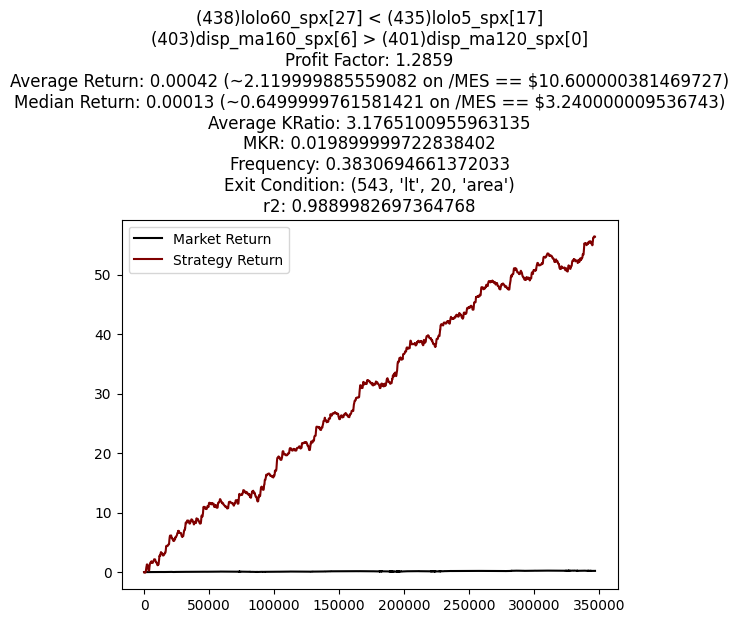

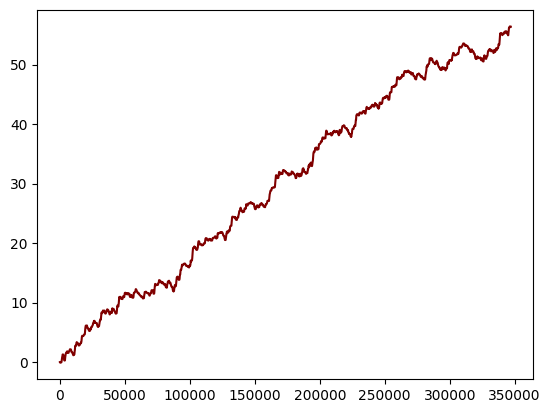

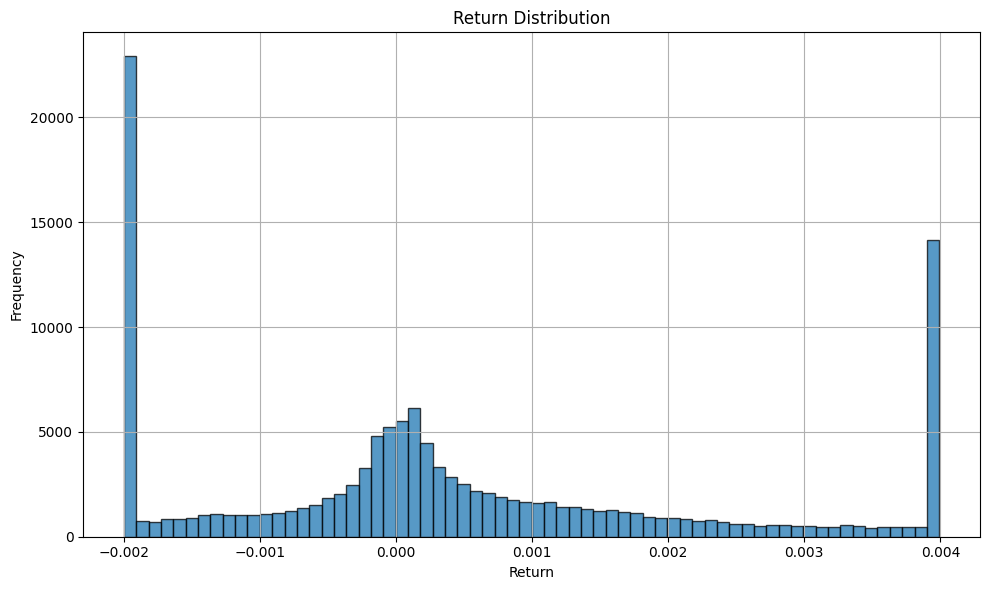

In [87]:
reload(_2)
print(_2.show_best_gene_patterns(endtime,criteria,fssd))
_2.show_returns(endtime[0]._array_returns, arr_close=arr_close, gene_kwargs={"population":endtime,"criteria":criteria,"fss":fssd,"exit_cond":exit_cond})

In [ ]:
'''new = _2.show_combined_performance(
    population=load_genes,
    arr_close=arr_close,
    arr_low=arr_low,
    arr_kratio=arr_kratio,
    arr_returns=arr_returns,
    data=dataset,
    hold_for=hold_for,
    lag_allow=lag_allowance,
    specific_data=None,
    log_normalize=log_normalize,
    criteria=criteria,
    fss=fssd
)'''